# Taming Transformers

This notebook is a minimal working example to generate landscape images as in [Taming Transformers for High-Resolution Image Synthesis](https://github.com/CompVis/taming-transformers). **tl;dr** We combine the efficiancy of convolutional approaches with the expressivity of transformers by introducing a convolutional VQGAN, which learns a codebook of context-rich visual parts, whose composition is modeled with an autoregressive transformer.

## Setup
The setup code in this section was written to be [run in a Colab environment](https://colab.research.google.com/github/CompVis/taming-transformers/blob/master/scripts/taming-transformers.ipynb). For a full, local setup, we recommend the provided [conda environment](https://github.com/CompVis/taming-transformers/blob/master/environment.yaml), as [described in the readme](https://github.com/CompVis/taming-transformers#requirements). This will also allow you to run a streamlit based demo.

Here, we first clone the repository and download a model checkpoint and config.

In [1]:
pwd

'/home/gx/taming-transformers/scripts'

In [2]:
%cd ..

/home/gx/taming-transformers


In [3]:
pwd

'/home/gx/taming-transformers'

In [4]:
# !git clone https://github.com/CompVis/taming-transformers
# %cd taming-transformers

# !mkdir -p logs/2020-11-09T13-31-51_sflckr/checkpoints
# !wget 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' -O 'logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt'
# !mkdir logs/2020-11-09T13-31-51_sflckr/configs
# !wget 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' -O 'logs/2020-11-09T13-31-51_sflckr/configs/2020-11-09T13-31-51-project.yaml'

Next, we install minimal required dependencies.

In [5]:
# %pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8

import sys
sys.path.append(".")

In [6]:
from PIL import Image
import numpy as np

## Loading the model

We load and print the config.

In [7]:
from omegaconf import OmegaConf

# config_path = "logs/2020-11-09T13-31-51_sflckr/configs/2020-11-09T13-31-51-project.yaml"
config_path = "logs/2021-12-23T10-29-31_wikiart_f16_16384_transformer2/configs/2021-12-23T10-29-31-project.yaml"
config = OmegaConf.load(config_path)

import yaml
print(yaml.dump(OmegaConf.to_container(config)))

data:
  params:
    batch_size: 16
    num_workers: 16
    train:
      params:
        size: 256
        training_images_list_file: /home/gx/taming-transformers/wikiart_abstract_art_train.txt
      target: taming.data.custom.CustomTrain
    validation:
      params:
        size: 256
        test_images_list_file: /home/gx/taming-transformers/wikiart_abstract_art_train.txt
      target: taming.data.custom.CustomTest
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    cond_stage_config: __is_unconditional__
    first_stage_config:
      params:
        ckpt_path: checkpoints/wikiart_f16_16384_8145600.ckpt
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 3
          num_res_blocks: 2
          out_ch: 3
          resolution: 256
          z_channels: 256
        em

Instantiate the model.

In [8]:
from taming.models.cond_transformer import Net2NetTransformer
model = Net2NetTransformer(**config.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from checkpoints/wikiart_f16_16384_8145600.ckpt
Using no cond stage. Assuming the training is intended to be unconditional. Prepending 0 as a sos token.


Load the (transformer) checkpoint.

In [9]:
import torch

# ckpt_path = "logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt"
ckpt_path = "logs/2021-12-23T10-29-31_wikiart_f16_16384_transformer2/testtube/version_0/checkpoints/epoch=14-step=76364.ckpt"

sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]

missing, unexpected = model.load_state_dict(sd, strict=False)

In [10]:
missing, unexpected

([], [])

In [11]:
model.cuda().eval()
torch.set_grad_enabled(False)

Our model also employs a VQGAN for the conditioning information, i.e. the segmentation in this example. Let's autoencode the segmentation map. Encoding returns both the quantized code and its representation in terms of indices of a learned codebook.

Let's sample indices corresponding to codes from the image VQGAN given the segmentation code. We init randomly and take a look.

code_size: 256
z_indices.shape: torch.Size([256])
z_code_shape: (1, 256, 16, 16)


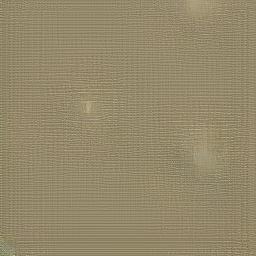

In [12]:
def show_image(s):
    s = s.detach().cpu().numpy().transpose(0, 2, 3, 1)[0]
    s = ((s + 1.0) * 127.5).clip(0, 255).astype(np.uint8)
    s = Image.fromarray(s)
    display(s)

code_size = config.model.params.first_stage_config.params.embed_dim
print(f"code_size: {code_size}")

z_indices_shape = (16 * 16,)
z_code_shape = (1, code_size, 16, 16)

z_indices = torch.randint(code_size, z_indices_shape, device=model.device)
print(f"z_indices.shape: {z_indices.shape}")
print(f"z_code_shape: {z_code_shape}")

# x_sample = model.decode_to_img(z_indices, z_code_shape)
x_sample = model.decode_to_img(z_indices, z_code_shape)
show_image(x_sample)

z_start_indices.shape: torch.Size([1, 0])
index_sample.shape: torch.Size([1, 256])
x_sample_nopix.shape: torch.Size([1, 3, 256, 256])


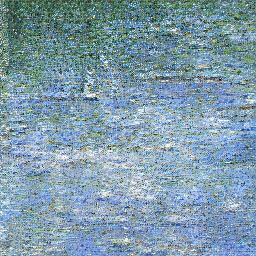

In [14]:
# sample
z_indices = torch.tensor([], dtype=torch.long, device=model.device).reshape(1, 0)
z_indices.shape

c_indices = torch.zeros(1, 1, dtype=torch.long, device=model.device)
c_indices.shape

z_start_indices = z_indices[:, :0]
print(f"z_start_indices.shape: {z_start_indices.shape}")

temperature = None
top_k = None

index_sample = model.sample(z_start_indices, 
                            c_indices,
#                             steps=z_indices.shape[1],
                            steps=256,
                            temperature=temperature if temperature is not None else 1.0,
                            sample=True,
                            top_k=top_k if top_k is not None else 100,
                            callback=lambda k: None)
print(f"index_sample.shape: {index_sample.shape}")

x_sample_nopix = model.decode_to_img(index_sample, (-1, code_size, 16, 16))
print(f"x_sample_nopix.shape: {x_sample_nopix.shape}")

show_image(x_sample_nopix[:1])

## Sample an image

We use the transformer in a sliding window manner to sample all code entries sequentially. The code below assumes a window size of $16\times 16$.

In [15]:
codebook_size = config.model.params.first_stage_config.params.n_embed
codebook_size

16384

Time: 10.2521071434021 seconds


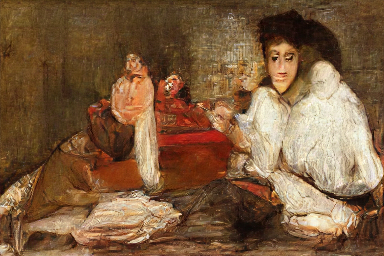

In [21]:
from IPython.display import clear_output
import time

B = 1
H = 16 * 1
W = 24 * 1
temperature = 1.0
top_k = 200
update_every = 50

# Initialize indices randomly
idx = torch.randint(codebook_size, (B, H * W), device=model.device)

x = torch.tensor([], 
                 dtype=torch.long, 
                 device=model.device).reshape(B, 0)
c = torch.full((B, 1), fill_value=model.sos_token, 
               dtype=torch.long, 
               device=model.device)

index_sample = model.sample(x, c,
                            steps=1,
                            temperature=temperature if temperature is not None else 1.0,
                            sample=True,
                            top_k=top_k if top_k is not None else 100,
                            callback=lambda k: None)
print(f"index_sample.shape: {index_sample.shape}")
print(f"index_sample: {index_sample}")

# 1/0

idx[0, :index_sample.shape[-1]] = index_sample
idx = idx.reshape(B, H, W)

start_t = time.time()
for i in range(0, H-0):
    if i <= 8:
        local_i = i
    elif H-i < 8:
        local_i = 16 - (H-i)
    else:
        local_i = 8

    for j in range(0, W-0):
        if j <= 8:
            local_j = j
        elif W-j < 8:
            local_j = 16 - (W-j)
        else:
            local_j = 8
            
        # local_i, local_j is where we extract the logits/probabilities from
        i_start = i - local_i
        i_end = i_start + 16
        j_start = j - local_j
        j_end = j_start + 16
        
        print(f"Step: ({i},{j}) | Local: ({local_i},{local_j}) | Crop: ({i_start}:{i_end},{j_start}:{j_end})")
    
        # Crop patch/sliding window
        patch = idx[:,i_start:i_end,j_start:j_end]
#         print(f"patch.shape: {patch.shape}")
        patch = patch.reshape(patch.shape[0], -1)
#         print(f"patch.shape: {patch.shape}")
    
        # Prepend conditioning code c to z
        patch = torch.cat((c, patch), dim=1)
        print(f"patch.shape: {patch.shape}")
    
        # Drop the last value to keep context within model block size of 16x16
        logits,_ = model.transformer(patch[:,:-1])
        print(f"logits.shape: {logits.shape}")
    
        # Take last 16x16 values
        logits = logits[:, -256:, :]
        
        # Reshape sequence to be of sliding window size
        logits = logits.reshape(B,16,16,-1)
    
        # Take the logits at (local_i,local_j)
        logits = logits[:,local_i,local_j,:]
    
        logits = logits/temperature

        if top_k is not None:
            logits = model.top_k_logits(logits, top_k)

        # Softmax to convert logits to probability
        probs = torch.nn.functional.softmax(logits, dim=-1)
        print(f"probs.shape: {probs.shape}")
        
        # Sample z code index from probabilities
        tmp = torch.multinomial(probs, num_samples=1)
        print(f"tmp.shape: {tmp.shape}")
        idx[:,i,j] = tmp

        step = i * W + j
        if step % update_every == 0 or step == H * W - 1:
            x_sample = model.decode_to_img(idx, (B, 256, H, W))
            
            clear_output()
            print(f"Time: {time.time() - start_t} seconds")

            show_image(x_sample)